### Index

[3. First Model](#3) <br>
- [XGBoost](#3.1)<br>
- [Cross-validate](#3.2)<br>
- [Plot Results](#3.3)<br>
- [Feature importance](#3.4)<br>

In [1]:
# !pip install utils
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.core.display import display, HTML
import sys, os
from time import time
from itertools import product
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score
from pathlib import Path
import talib
import time
import statistics
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, 
                                     cross_val_predict, 
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import statistics
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from statistics import *
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_columns = None

In [3]:
display(HTML("<style> *{margin:0; padding:0;} html, body, \
             .container{margin:2;!important padding:0;!important} \
             .container { width:100% !important;}</style>"))

In [4]:
df = pd.read_csv('../SampleDataSet.csv')

#convert to datetime
df['DATE'] = pd.to_datetime(df['DATE'])
descr = df.describe()
#merge duplicated row
df = df.groupby(['RP_ENTITY_ID', 'DATE'], as_index=False).first()
### drop col with 100% NA
cols_to_drop = descr.columns[descr.loc['count',:]==0]
df = df.loc[:, ~df.columns.isin(cols_to_drop)]
#retain assets with a min of 3year of data
nb_date_ceil = 15000
nb_date_floor = 756 #3y track record
list_asset = df.RP_ENTITY_ID.value_counts().loc[(df.RP_ENTITY_ID.value_counts()<nb_date_ceil)&(df.RP_ENTITY_ID.value_counts()>nb_date_floor)].index
list_asset = list(list_asset)
df = df.loc[df['RP_ENTITY_ID'].isin(list_asset),:]
#use log_return
df['T0_RETURN_log'] = np.log(1+df.loc[:,'T0_RETURN'].copy()) ##use log return
df['T1_RETURN_log'] = np.log(1+df.loc[:,'T1_RETURN'].copy()) ##use log return
cols_to_drop = ['T0_RETURN', 'T1_RETURN']
df0 = df.loc[:, ~df.columns.isin(cols_to_drop)].copy()

In [5]:
len(list_asset)

256

In [6]:
# %store -r cluster_dict
# %store -r add_features
# %store -r dataset

In [7]:
df0['cluster'] = df0['RP_ENTITY_ID'].map(cluster_dict)
df0 = df0.dropna(subset=['cluster'])
df0['cluster'] = df0['cluster'].astype('int64')

In [8]:
df0 =  pd.merge(df0, add_features.reset_index(), on=['RP_ENTITY_ID','DATE'], how='outer') 

___
#  <a id =3> </a> **3. First Model**
___

# <a id =3.1> </a> XGBOOST

In [9]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [10]:

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time, MultipleTimeSeriesCV

In [11]:
results_path = Path('results', 'baseline')
if not results_path.exists():
    results_path.mkdir(exist_ok=True, parents=True)

In [12]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

In [13]:
df = df0.set_index(['RP_ENTITY_ID', 'DATE']).copy()
df_i = df.copy()
df_i = df_i.dropna(subset=['T1_RETURN_log'])


In [14]:
def get_data(start='2010', end='2016', task='classification', holding_period=1, dropna=False):
    
    idx = pd.IndexSlice
    target = 'T1_RETURN_log'
    ddf = df_i.copy()

    if start is not None and end is not None:
        ddf = ddf.loc[idx[:, start: end], :]
    if dropna:
        ddf = ddf.dropna()
        
    y = (ddf[target]>0).astype(int)
    X = ddf.loc[:,~ddf.columns.str.contains('T1_RETURN')]
    return y, X

In [16]:
y, X = get_data()
X =  pd.get_dummies(X,
                        columns=['cluster'],
                        prefix=['cluster'],
                        prefix_sep=['_'])

X = X.loc[:, ~X.columns.isin(['GROUP_E_BODY', 'GROUP_A_BODY', 'GROUP_AM_BODY'])]

In [17]:
train_period_length = 74
test_period_length = 21
YEAR = 252
n_splits = int(6 * YEAR / test_period_length) # 6 years
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [18]:
run_time = {}

In [19]:
metrics = {'balanced_accuracy': 'Accuracy' ,
#            'roc_auc': 'AUC',
#            'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

In [20]:
def run_cv(clf, X=X, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(estimator=clf,
                            X=X, 
                            y=y,
                            scoring=list(metrics.keys()),
                            cv=cv,
                            return_train_score=True,
                            n_jobs=n_jobs,
                            verbose=1,
                            fit_params=fit_params)
    duration = time() - start
    return scores, duration

In [21]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [22]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9)
    if fname:
        g.savefig(fname, dpi=300);

In [23]:
xgb_clf = XGBClassifier(max_depth=3,       #3           # Maximum tree depth for base learners.
                        learning_rate=0.4,  #0.4          # Boosting learning rate (xgb's "eta")
                        n_estimators=100,   #500          # Number of boosted trees to fit.
                        silent=False,                  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',             # Select booster: gbtree, gblinear or dart
                        tree_method='gpu_hist',
                        n_jobs=16,                    # Number of parallel threads
                        gamma=0,                      # Min loss reduction for further splits
                        min_child_weight=1,           # Min sum of sample weight(hessian) needed
                        max_delta_step=0,             # Max delta step for each tree's weight estimation
                        subsample=1,                  # Subsample ratio of training samples
                        colsample_bytree=1,           # Subsample ratio of cols for each tree
                        colsample_bylevel=1,          # Subsample ratio of cols for each split
                        reg_alpha=0,                  # L1 regularization term on weights
                        reg_lambda=1,                 # L2 regularization term on weights
                        scale_pos_weight=1,           # Balancing class weights
                        base_score=0.5,               # Initial prediction score; global bias
                        random_state=42)              # random seed

### <a id =3.2> </a> Cross-validate

In [24]:
algo = 'xgboost'
xgb_cv_result, run_time[algo] = run_cv(xgb_clf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


11007 Int64Index([   920,    921,    922,    923,    924,    925,    926,    927,
               928,    929,
            ...
            225075, 225076, 225077, 225078, 225079, 225080, 225081, 225082,
            225083, 225084],
           dtype='int64', length=11007) 3291 Int64Index([   977,    978,    979,    980,    981,    982,    983,    984,
               985,    986,
            ...
            225088, 225089, 225090, 225091, 225092, 225093, 225094, 225095,
            225096, 225097],
           dtype='int64', length=3291)
11762 Int64Index([   899,    900,    901,    902,    903,    904,    905,    906,
               907,    908,
            ...
            225065, 225066, 225067, 225068, 225069, 225070, 225071, 225072,
            225073, 225074],
           dtype='int64', length=11762) 2866 Int64Index([   960,    961,    962,    963,    964,    965,    966,    967,
               968,    969,
            ...
            225075, 225076, 225077, 225078, 225079, 225080, 2250

9912 Int64Index([   652,    653,    654,    655,    656,    657,    658,    659,
               660,    661,
            ...
            224853, 224854, 224855, 224856, 224857, 224858, 224859, 224860,
            224861, 224862],
           dtype='int64', length=9912) 2631 Int64Index([   715,    716,    717,    718,    719,    720,    721,    722,
               723,    724,
            ...
            224115, 224116, 224863, 224864, 224865, 224866, 224867, 224868,
            224869, 224870],
           dtype='int64', length=2631)
9601 Int64Index([   640,    641,    642,    643,    644,    645,    646,    647,
               648,    649,
            ...
            224840, 224841, 224842, 224843, 224844, 224845, 224846, 224847,
            224848, 224849],
           dtype='int64', length=9601) 3085 Int64Index([   694,    695,    696,    697,    698,    699,    700,    701,
               702,    703,
            ...
            224853, 224854, 224855, 224856, 224857, 224858, 224859, 

9485 Int64Index([   490,    491,    492,    493,    494,    495,    496,    497,
               498,    499,
            ...
            224702, 224703, 224704, 224705, 224706, 224707, 224708, 224709,
            224710, 224711],
           dtype='int64', length=9485) 3099 Int64Index([   531,    532,    533,    534,    535,    536,    537,    538,
               539,   1633,
            ...
            224047, 224712, 224713, 224714, 224715, 224716, 224717, 224718,
            224719, 224720],
           dtype='int64', length=3099)
9169 Int64Index([   483,    484,    485,    486,    487,    488,    489,    490,
               491,    492,
            ...
            224696, 224697, 224698, 224699, 224700, 224701, 224702, 224703,
            224704, 224705],
           dtype='int64', length=9169) 2573 Int64Index([   519,    520,    521,    522,    523,    524,    525,    526,
               527,    528,
            ...
            223452, 223453, 224040, 224041, 224706, 224707, 224708, 

9362 Int64Index([   327,    328,    329,    330,    331,    332,    333,    334,
               335,    336,
            ...
            224549, 224550, 224551, 224552, 224553, 224554, 224555, 224556,
            224557, 224558],
           dtype='int64', length=9362) 2448 Int64Index([   368,    369,    370,    371,    372,    373,    374,    375,
              1433,   1434,
            ...
            223333, 223951, 223952, 223953, 224559, 224560, 224561, 224562,
            224563, 224564],
           dtype='int64', length=2448)
9522 Int64Index([   314,    315,    316,    317,    318,    319,    320,    321,
               322,    323,
            ...
            224537, 224538, 224539, 224540, 224541, 224542, 224543, 224544,
            224545, 224546],
           dtype='int64', length=9522) 2394 Int64Index([   357,    358,    359,    360,    361,    362,    363,    364,
               365,    366,
            ...
            224549, 224550, 224551, 224552, 224553, 224554, 224555, 

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s


8735 Int64Index([   151,    152,    153,    154,    155,    156,    157,    158,
               159,    160,
            ...
            224424, 224425, 224426, 224427, 224428, 224429, 224430, 224431,
            224432, 224433],
           dtype='int64', length=8735) 2300 Int64Index([   187,    188,    189,    190,    191,    192,    193,    194,
               195,    196,
            ...
            223213, 223875, 223876, 224434, 224435, 224436, 224437, 224438,
            224439, 224440],
           dtype='int64', length=2300)
9096 Int64Index([   136,    137,    138,    139,    140,    141,    142,    143,
               144,    145,
            ...
            224416, 224417, 224418, 224419, 224420, 224421, 224422, 224423,
            224424, 224425],
           dtype='int64', length=9096) 2511 Int64Index([   176,    177,    178,    179,    180,    181,    182,    183,
               184,    185,
            ...
            223873, 223874, 224426, 224427, 224428, 224429, 224430, 

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   14.7s finished


### <a id =3.3> </a> Plot Results

In [25]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()


Dataset,Test,Train
Metric,,
Accuracy,0.501,0.653
F1,0.497,0.653
Precision,0.502,0.659
Recall,0.502,0.656


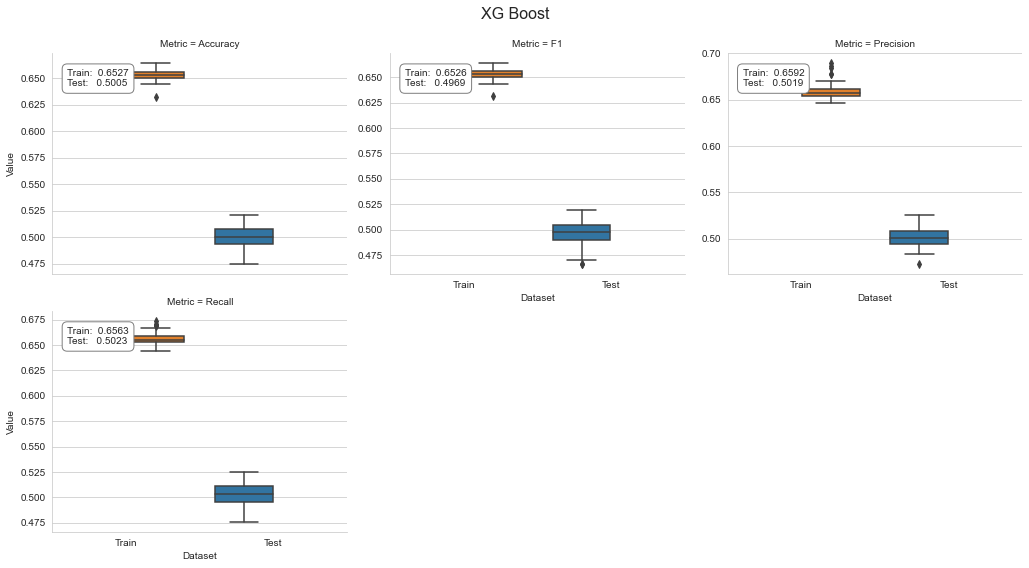

In [26]:
plot_result(xbg_result, model='XG Boost')#, fname=f'figures/{algo}_cv_result')

### <a id =3.4> </a> Feature Importance

In [27]:
xgb_clf.fit(X=X, y=y)

[18:05:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:05:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.4, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=False,
              subsample=1, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)

In [28]:
fi = pd.Series(xgb_clf.feature_importances_, 
               index=X.columns)

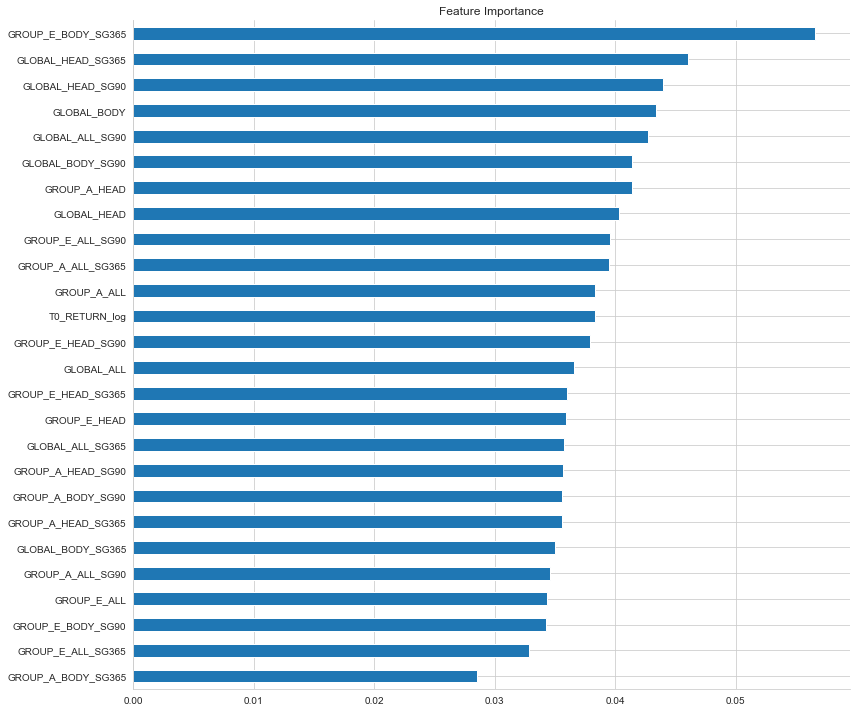

In [29]:
fi.nlargest(70).sort_values().plot.barh(figsize=(12, 10), 
                                        title='Feature Importance')
sns.despine()
plt.tight_layout();

In [30]:
# import torch
# torch.cuda.empty_cache()

In [31]:
i = 0
for train_idx, test_idx in cv.split(X=X):
    train = X.iloc[train_idx]
    train_dates = train.index.get_level_values('DATE')
    test = X.iloc[test_idx]
    test_dates = test.index.get_level_values('DATE')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='RP_ENTITY_ID').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='RP_ENTITY_ID').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

11007 Int64Index([   920,    921,    922,    923,    924,    925,    926,    927,
               928,    929,
            ...
            225075, 225076, 225077, 225078, 225079, 225080, 225081, 225082,
            225083, 225084],
           dtype='int64', length=11007) 3291 Int64Index([   977,    978,    979,    980,    981,    982,    983,    984,
               985,    986,
            ...
            225088, 225089, 225090, 225091, 225092, 225093, 225094, 225095,
            225096, 225097],
           dtype='int64', length=3291)
73 2016-08-18 2016-11-30 21 2016-12-01 2016-12-30
11762 Int64Index([   899,    900,    901,    902,    903,    904,    905,    906,
               907,    908,
            ...
            225065, 225066, 225067, 225068, 225069, 225070, 225071, 225072,
            225073, 225074],
           dtype='int64', length=11762) 2866 Int64Index([   960,    961,    962,    963,    964,    965,    966,    967,
               968,    969,
            ...
            22